In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread_collection
import cv2
from PIL import Image
from scipy.spatial.distance import cdist

In [3]:
def compute_within_class(m,X):
    Sw = np.zeros((m.shape[1],m.shape[1]))
    for i in range(9*15):
        temp = (X[i]-m[i//9]).reshape(-1,1)
        Sw += np.dot(temp,temp.T)
    return Sw

In [4]:
def compute_between_class(m,M):
    Sb = np.zeros((m.shape[1],m.shape[1]))
    for i in range(15):
        temp = (m[i]-M).reshape(-1,1)
        Sb += np.dot(temp,temp.T)*9
    return Sb

In [5]:
def compute_mean(X):
    m = np.zeros((15,X.shape[1]))
    M = np.zeros(X.shape[1])
    for i in range(15):
        m[i] = np.mean(X[i*9:(i+1)*9,:],axis=0)
    M = np.mean(X,axis=0)
    return m,M

In [24]:
def cal_acc(pred,y):
    acc = 0
    for i in range(pred.shape[0]):
        if pred[i]==y[i]:
            acc+=1
    return acc/pred.shape[0]

In [49]:
def knn(k,Tr,Ts,y):
    pred = np.zeros(Ts.shape[0])
    dist = cdist(Tr,Ts,'euclidean').T
    rank = dist.argsort()[::1][:,:k]//9
    for i in range(Ts.shape[0]):
        unique, counts = np.unique(rank[i], return_counts=True)
        pred[i] = unique[counts.argmax()]
    return cal_acc(pred,y)

In [130]:
def rbf_kernel(X1,X2,sigma=-0.02):
    W = np.zeros((X1.shape[0],X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            w = np.exp(sigma*(np.linalg.norm(X1[i]-X2[j])**2))
            W[i,j] = w
    return W

In [131]:
def poly_kernel(X1,X2,d=3):
    return np.dot(X1.T,X2)**d

In [6]:
def im_concatenate(im):
    res = np.concatenate((im[:,0].reshape(new_shape),
                          im[:,1].reshape(new_shape),
                          im[:,2].reshape(new_shape),
                          im[:,3].reshape(new_shape),
                          im[:,4].reshape(new_shape)),axis=1)
    for i in range(1,5):
        temp = np.concatenate((im[:,i*5+0].reshape(new_shape),
                               im[:,i*5+1].reshape(new_shape),
                               im[:,i*5+2].reshape(new_shape),
                               im[:,i*5+3].reshape(new_shape),
                               im[:,i*5+4].reshape(new_shape)),axis=1)
        res = np.concatenate((res,temp),axis=0)
    return res

In [7]:
def plot_reconstruct(reconstruct):
    re = reconstruct[0].reshape(115,97)
    for i in range(1,5):
        re = np.concatenate((re,reconstruct[i].reshape(115,97)),axis=1)
    re2 = reconstruct[5].reshape(115,97)
    for i in range(6,10):
        re2 = np.concatenate((re2,reconstruct[i].reshape(115,97)),axis=1)
    re = np.concatenate((re,re2),axis=0)
    plt.imshow(re,cmap='binary')
    plt.imsave('png/eigenface_reconstruct.png',re,cmap='binary')

In [8]:
im_shape = (231,195)
new_shape = (115,97)
train_im = np.array(imread_collection('Yale_Face_Database/Training/*.pgm'))
test_im = np.array(imread_collection('Yale_Face_Database/Testing/*.pgm'))
train = np.zeros((train_im.shape[0],115*97))
test = np.zeros((test_im.shape[0],115*97))

In [9]:
for i in range(train_im.shape[0]):
    train[i] = cv2.resize(train_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)/255
for i in range(test_im.shape[0]):
    test[i] = cv2.resize(test_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)/255

In [46]:
train_label = []
test_label = []
for i in range(15):
    train_label.append([i]*9)
    test_label.append([i]*2)
train_label = np.array(train_label).reshape(-1)
test_label = np.array(test_label).reshape(-1)

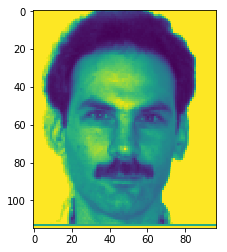

In [43]:
plt.imshow(train[9].reshape(115,97))

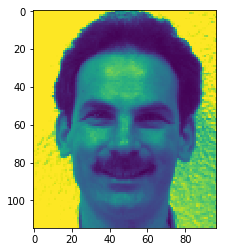

In [42]:
plt.imshow(test[2].reshape(115,97))

In [12]:
# PCA
cov = np.cov(train.transpose())
eigen_values, eigen_vectors = np.linalg.eigh(cov)
W_pca = eigen_vectors[:,eigen_values.argsort()[::-1]]

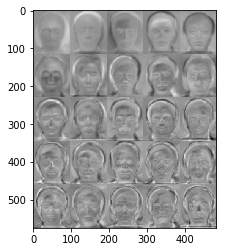

In [13]:
plt.imshow(im_concatenate(W_pca[:,:25]),cmap='binary')
plt.imsave('png/eigenface.png',im_concatenate(W_pca[:,:25]),cmap='binary')

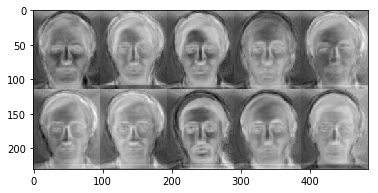

In [14]:
reconstruct = np.dot(np.dot(train[sorted(np.random.choice(135,10)),:],W_pca[:,:25]),W_pca[:,:25].T)
plot_reconstruct(reconstruct)

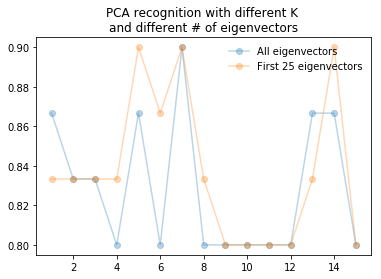

In [94]:
acc = np.zeros((2,15))
for i in range(15):
    acc[0][i] = knn(i+1,np.dot(train,W_pca),np.dot(test,W_pca),test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_pca[:,:25]),np.dot(test,W_pca[:,:25]),test_label)

plt.plot(np.linspace(1,15,15),acc[0],'o-',alpha=0.3)
plt.plot(np.linspace(1,15,15),acc[1],'o-',alpha=0.3)
plt.legend(['All eigenvectors','First 25 eigenvectors'],loc='best',frameon=False)
plt.title('PCA recognition with different K \nand different # of eigenvectors')
plt.savefig('png/PCA_recog.png')

In [137]:
e = np.ones((135,135))/135
K = rbf_kernel(train,train)
Kc = K - np.dot(e,K) - np.dot(K,e) + np.dot(np.dot(e,K),e)
eigen_values3, eigen_vectors3 = np.linalg.eig(Kc)
U = eigen_vectors3[:,eigen_values3.argsort()[::-1]]
U

array([[-8.11724377e-03, -1.18543402e-02, -1.30064339e-02, ...,
        -6.92656157e-05, -8.60662966e-02, -4.63055972e-17],
       [-9.34577529e-03, -1.40095095e-02, -1.61109815e-02, ...,
        -5.87944135e-05, -8.60662966e-02,  2.45306598e-16],
       [-9.10228120e-03, -1.35768625e-02, -1.54738844e-02, ...,
        -6.05087234e-05, -8.60662966e-02, -1.25765232e-16],
       ...,
       [-1.00036255e-02, -1.52369900e-02, -1.79335822e-02, ...,
        -5.29741941e-05, -8.60662966e-02,  5.00543681e-16],
       [-8.60122909e-03, -1.26957740e-02, -1.41982438e-02, ...,
        -6.47480523e-05, -8.60662966e-02, -1.86476430e-16],
       [-8.40965916e-03, -1.23627533e-02, -1.37266481e-02, ...,
        -6.65374334e-05, -8.60662966e-02, -2.39283309e-16]])

In [138]:
K

array([[1.00000000e+00, 3.97159679e-06, 1.49389897e-07, ...,
        2.96152100e-10, 3.31786253e-11, 3.63960021e-10],
       [3.97159679e-06, 1.00000000e+00, 2.47700478e-02, ...,
        9.95133771e-10, 4.28742958e-11, 3.28629406e-10],
       [1.49389897e-07, 2.47700478e-02, 1.00000000e+00, ...,
        1.28228508e-10, 3.93282889e-12, 1.46487779e-11],
       ...,
       [2.96152100e-10, 9.95133771e-10, 1.28228508e-10, ...,
        1.00000000e+00, 1.85515036e-04, 5.58703666e-05],
       [3.31786253e-11, 4.28742958e-11, 3.93282889e-12, ...,
        1.85515036e-04, 1.00000000e+00, 5.26122218e-03],
       [3.63960021e-10, 3.28629406e-10, 1.46487779e-11, ...,
        5.58703666e-05, 5.26122218e-03, 1.00000000e+00]])

In [140]:
Kt = rbf_kernel(train[0].reshape(1,-1),train)

In [141]:
Kt

array([[1.00000000e+00, 3.97159679e-06, 1.49389897e-07, 3.69503859e-07,
        3.90178192e-13, 2.25956673e-07, 7.74946927e-06, 9.43353362e-08,
        4.17488783e-06, 6.28208625e-09, 4.01480161e-08, 7.09440058e-09,
        4.60548820e-08, 1.02618929e-09, 5.37187090e-08, 5.72041253e-09,
        5.91276457e-08, 5.09422405e-09, 1.04100879e-07, 1.60068396e-10,
        3.09211898e-09, 2.26319029e-13, 6.15405541e-09, 1.35523543e-17,
        5.44388636e-09, 1.56230821e-10, 2.65537107e-09, 3.98561146e-08,
        8.52604957e-10, 6.78342529e-13, 1.27397347e-09, 1.15590617e-09,
        8.13491858e-10, 6.46206379e-10, 2.11648851e-10, 1.76850341e-09,
        2.78912933e-14, 1.95950902e-13, 1.99074898e-13, 3.26374261e-14,
        7.68931298e-14, 2.68669893e-16, 2.56535479e-13, 2.04065901e-13,
        6.71638044e-13, 6.61069307e-07, 6.84643739e-09, 1.01653796e-08,
        7.01853161e-08, 9.15356229e-10, 6.52774572e-07, 5.71144110e-09,
        1.52017733e-08, 1.25477805e-07, 8.31315535e-10, 3.805714

In [135]:
np.dot(Kc,U)[0]

array([-2.03371301e-02, -2.36702847e-02, -2.13384970e-02,  1.77651977e-02,
       -1.55214805e-02, -2.07496596e-02,  1.57442693e-02, -1.18157020e-02,
       -1.14994442e-02,  1.24470003e-02,  1.67228206e-02,  1.31301554e-02,
       -1.65486976e-02,  1.72023450e-02, -9.88228500e-03,  1.14161952e-02,
       -1.00244429e-02, -6.04490121e-03, -7.46457768e-04,  3.13823449e-03,
        9.88000576e-03,  7.20572192e-03,  8.10585727e-03, -4.84061757e-03,
       -9.92386771e-03,  1.07775604e-02, -5.35012509e-03,  1.10306234e-02,
        7.37366375e-03,  9.18699500e-03, -8.19539936e-03,  5.97379246e-03,
        9.12185030e-03,  9.52114029e-03, -1.14641596e-02,  1.15710802e-02,
        1.01759398e-02,  8.99682185e-03,  1.11785493e-02, -6.93782894e-03,
        6.04629220e-03, -1.30517226e-02,  8.74752463e-02,  3.74026535e-03,
       -2.77362828e-02, -1.79663577e-02, -4.30830170e-03, -6.71766903e-03,
        7.54934257e-03,  1.68295319e-03,  7.81263702e-03,  9.55497787e-03,
        2.79248659e-02, -

In [15]:
# LDA
train_project = np.dot(train,W_pca[:,:135-15]) # rank(Sw) is at most N-c
m,M = compute_mean(train_project)
Sw = compute_within_class(m,train_project)
Sb = compute_between_class(m,M)
eigen_values2, eigen_vectors2 = np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
W_fld = eigen_vectors2[:,eigen_values2.real.argsort()[::-1]].real
W_lda=np.dot(W_pca[:,:120],W_fld)

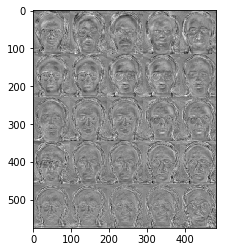

In [16]:
plt.imshow(im_concatenate(W_lda[:,:25].astype('float32')),cmap='binary')
plt.imsave('png/fisherface.png',im_concatenate(W_lda[:,:25].astype('float32')),cmap='binary')

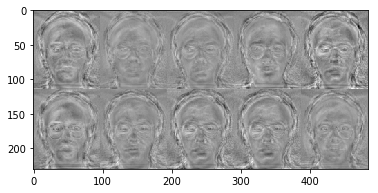

In [17]:
reconstruct2 = np.dot(np.dot(train[sorted(np.random.choice(135,10)),:],W_lda[:,:25]),W_lda[:,:25].T)
plot_reconstruct(reconstruct2)

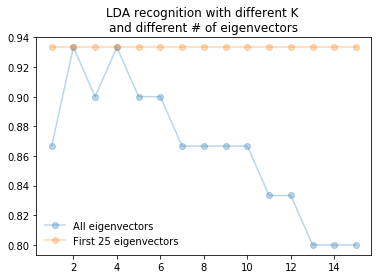

In [96]:
acc = np.zeros((2,15))
for i in range(15):
    acc[0][i] = knn(i+1,np.dot(train,W_lda),np.dot(test,W_lda),test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_lda[:,:25]),np.dot(test,W_lda[:,:25]),test_label)

plt.plot(np.linspace(1,15,15),acc[0],'o-',alpha=0.3)
plt.plot(np.linspace(1,15,15),acc[1],'o-',alpha=0.3)
plt.legend(['All eigenvectors','First 25 eigenvectors'],loc='best',frameon=False)
plt.title('LDA recognition with different K \nand different # of eigenvectors')
plt.savefig('png/LDA_recog.png')

In [104]:
np.linalg.norm([1,2])**2

5.000000000000001

In [102]:
train[0]-train[1]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.01176471])